<a href="https://colab.research.google.com/github/ssunsonic/ML_Project/blob/main/Image_Preprocessing_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Preprocessing and Initial CNN Rough Draft

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from PIL import Image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

Moved all test images into train folder since we can just split them into train and test anyway

In [11]:
destiny = '/content/drive/MyDrive/Colab Notebooks/ECS171/images/'
dataset = tf.keras.utils.image_dataset_from_directory(destiny)

Found 4320 files belonging to 2 classes.


In [7]:
len(dataset)
#hello

135

In [8]:
# dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['chihuahua', 'muffin']


### Split into Train/Validation

In [12]:
ds_train = tf.keras.utils.image_dataset_from_directory(destiny,
            validation_split=0.2, subset = 'training', seed = 1)
ds_val = tf.keras.utils.image_dataset_from_directory(destiny,
            validation_split=0.2, subset = 'validation', seed = 1)

Found 4320 files belonging to 2 classes.
Using 3456 files for training.
Found 4320 files belonging to 2 classes.
Using 864 files for validation.


In [18]:
# observing class split in training set
classes = []

for images, labels in ds_train.map(lambda x, y: (x, y)):
  # print(labels)
  classes.append(labels)

In [19]:
classes = np.concatenate(classes)

In [17]:
classes = pd.DataFrame(classes)
classes.value_counts()

1    1870
0    1586
dtype: int64

There is a slight class imbalance in the training set above. The difference isn't too large, however, such that a decision to resample should be considered in my opinion.

## Image Resizing

In [20]:
# size of images we want to resize to
size = (50,50)

In [21]:
# resize all images
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))

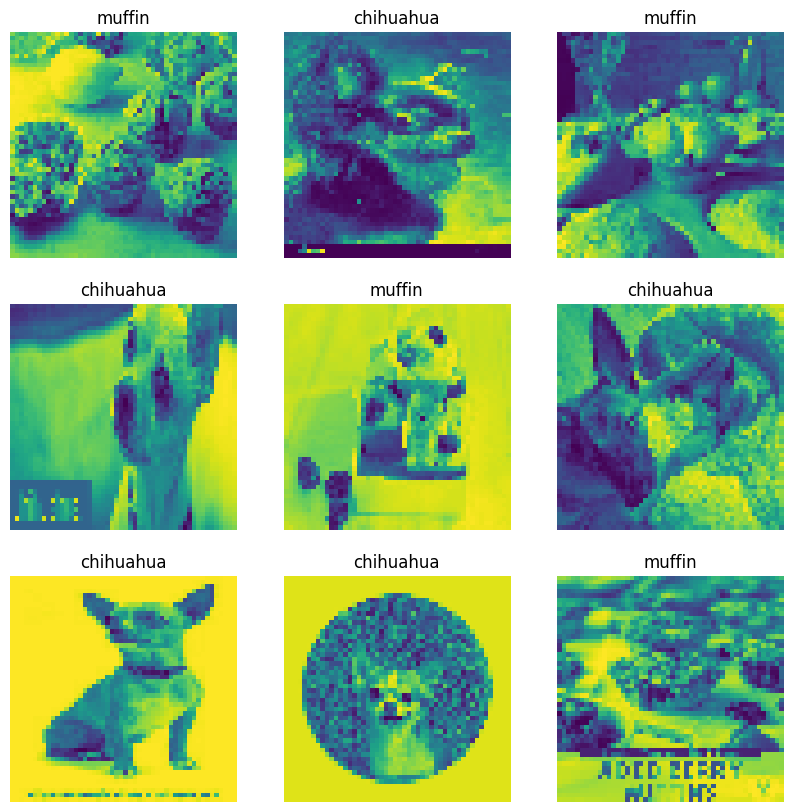

In [201]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  # display 9 resized images
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Greyscaling

In [23]:
ds_train = ds_train.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))
ds_val = ds_val.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))

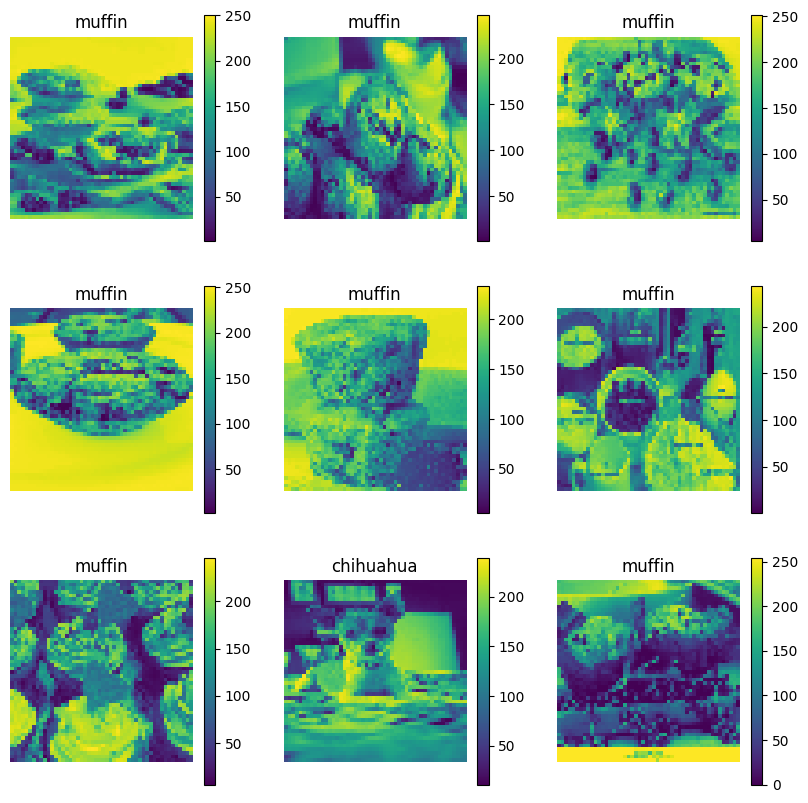

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.colorbar()

## Modeling

### CNN Keras Model


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# model = Sequential()
# # grayscaled images only have one channel not 3 for typical RGB
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# # softmax to output probability predictions
# model.add(layers.Dense(1, activation = 'sigmoid'))

In [26]:
model = Sequential()
# grayscaled images only have one channel not 3 for typical RGB
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
# softmax to output probability predictions
model.add(layers.Dense(1, activation = 'sigmoid'))

In [27]:
from keras.losses import binary_crossentropy
# compile model
model.compile(optimizer = 'adam', loss = binary_crossentropy, metrics = ['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3872)              0         
                                                                 
 dense (Dense)               (None, 32)                1

Observe the images in every layer

In [29]:
layer_names = []

for layer in model.layers[:4]:
  layer_names.append(layer.name)
print(layer_names)

['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1']


In [30]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(ds_train)

108/108 [==============================] - 26s 224ms/step


(3456, 48, 48, 32)


<ipython-input-31-53118c29512f>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')


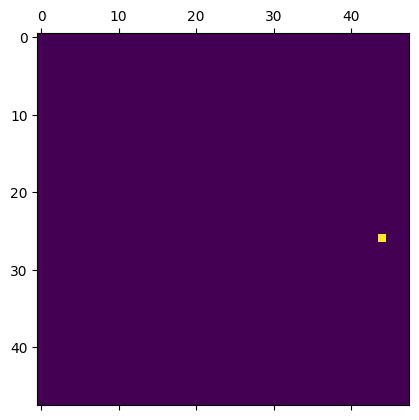

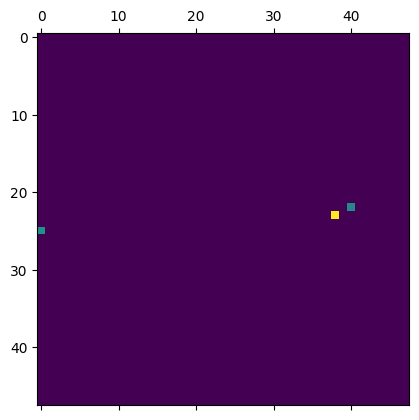

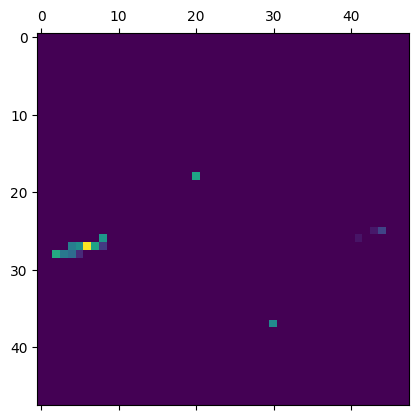

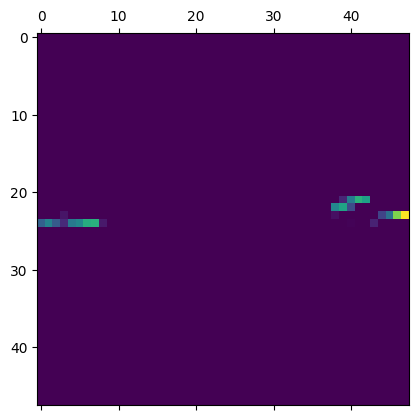

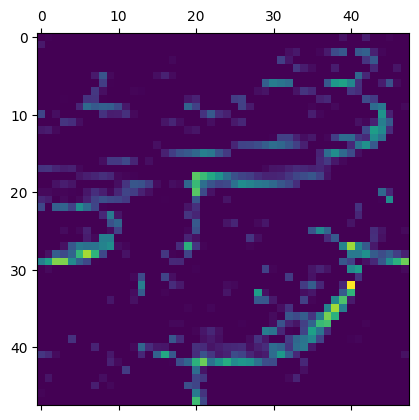

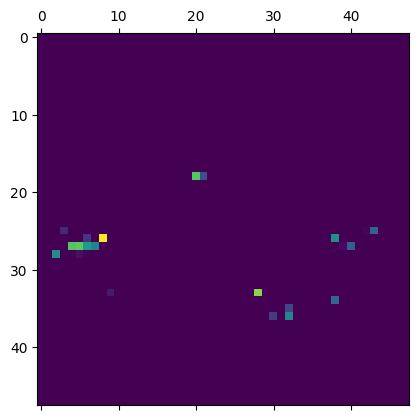

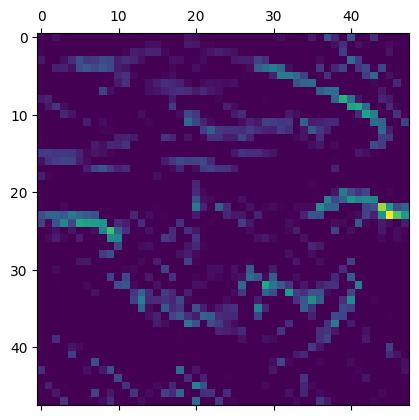

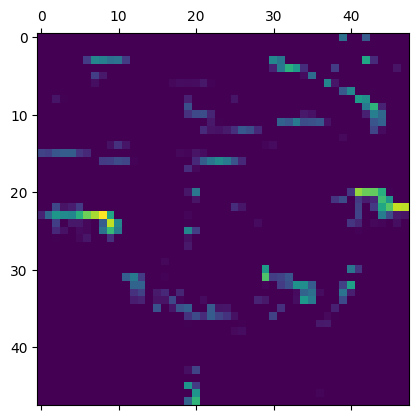

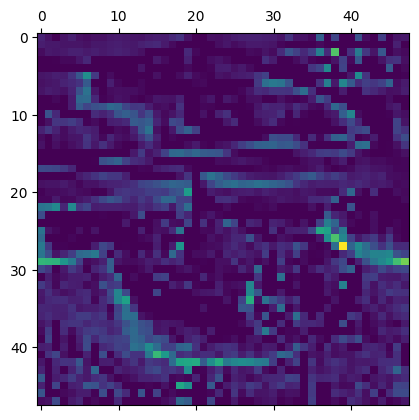

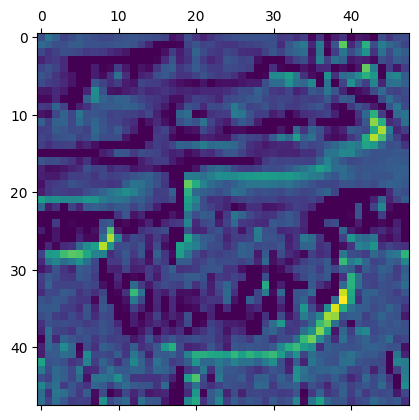

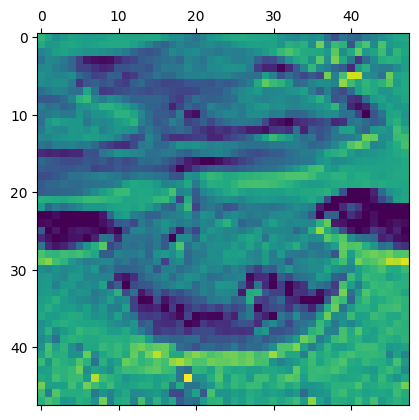

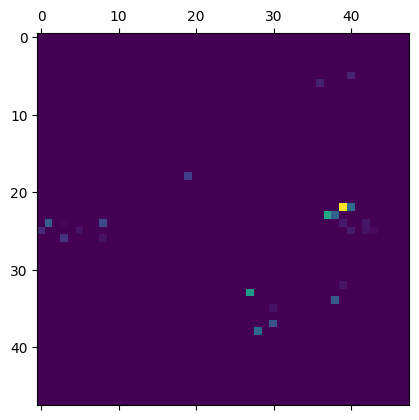

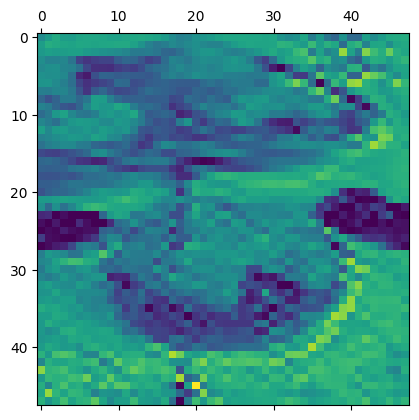

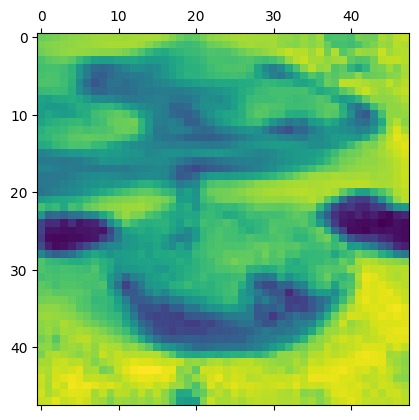

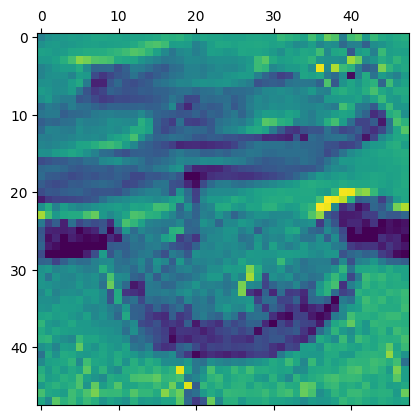

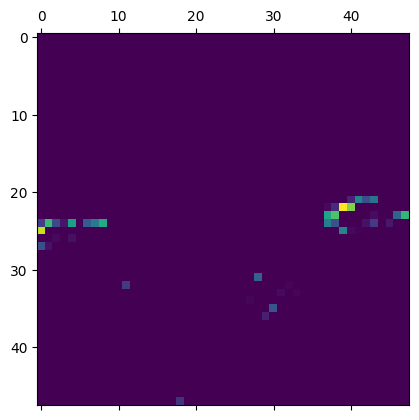

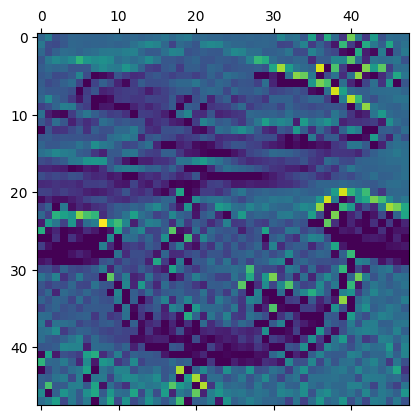

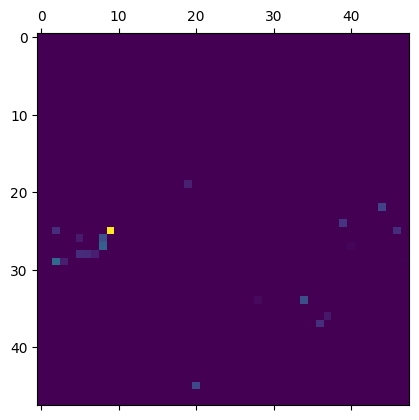

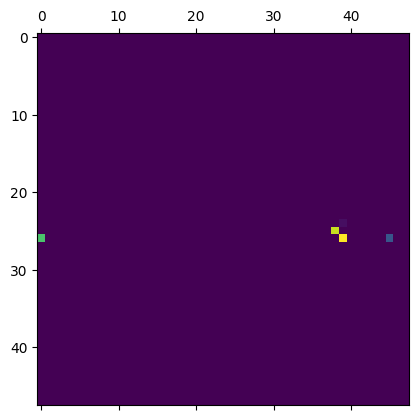

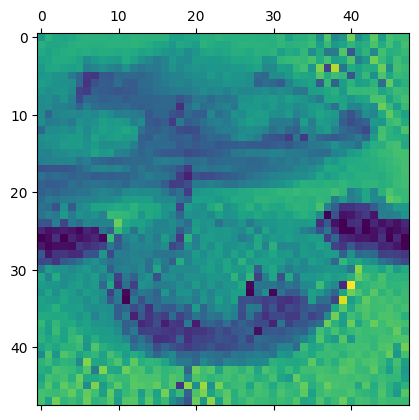

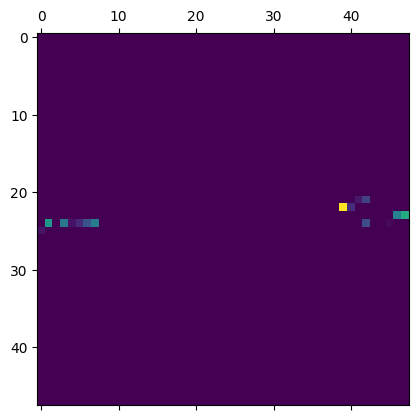

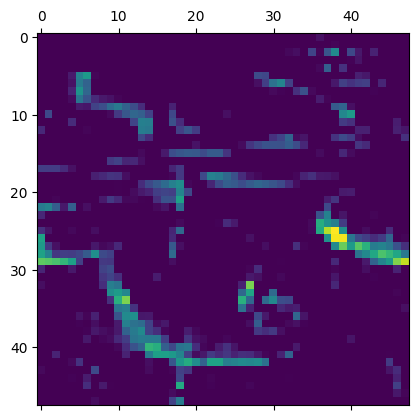

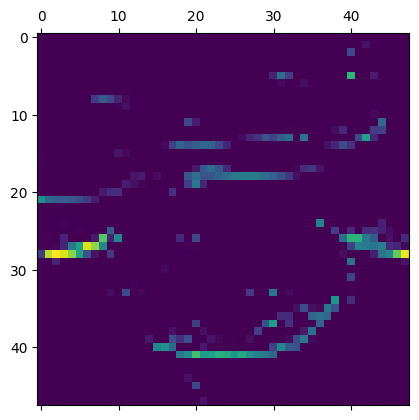

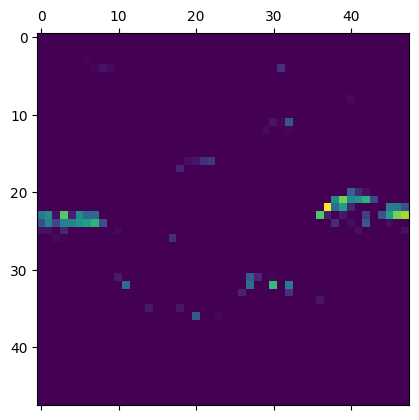

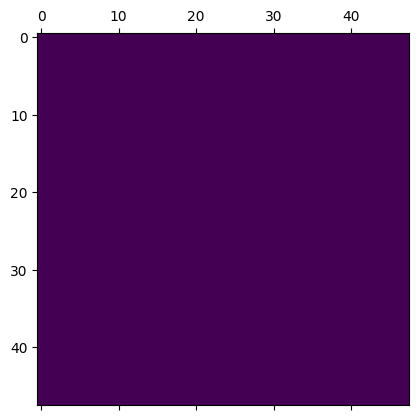

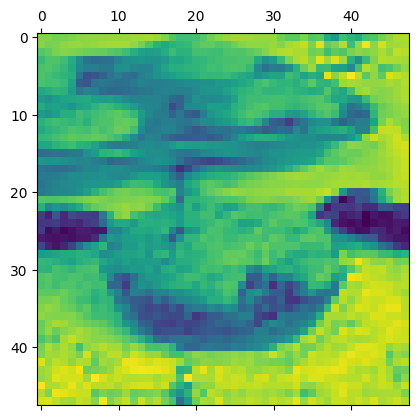

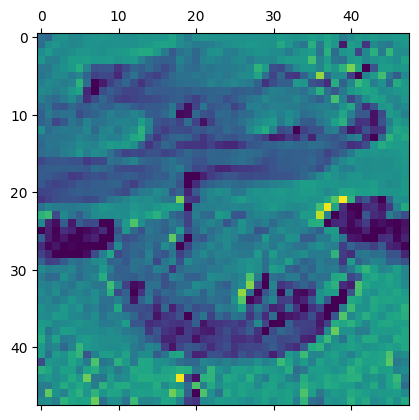

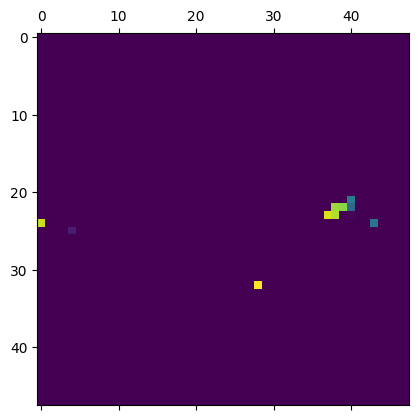

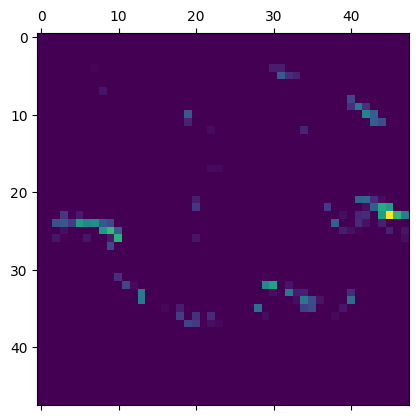

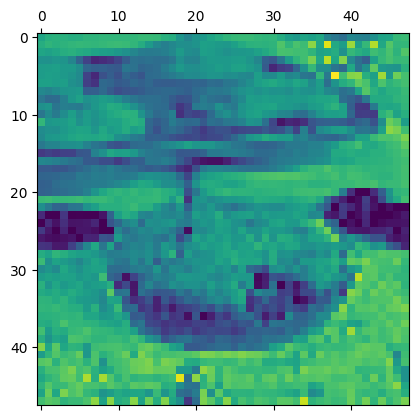

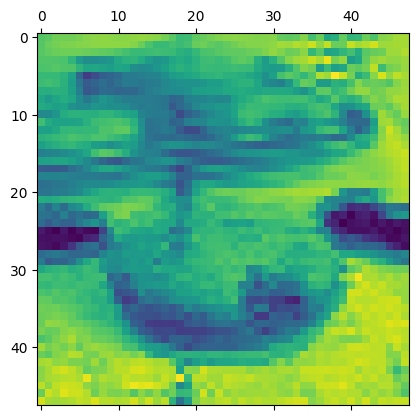

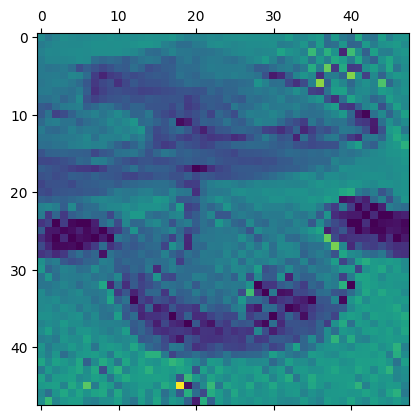

In [31]:
# # Getting Activations of first layer
first_layer_activation = activations[0]

# # shape of first layer activation
print(first_layer_activation.shape)

for i in range(first_layer_activation.shape[3]):
  # plt.subplot(4, 8, i + 1)
  plt.matshow(first_layer_activation[0, :, :, i], cmap ='viridis')

In [307]:
history = model.fit(ds_train, validation_data = ds_val, epochs = 10, batch_size = 10000)

Epoch 1/10
108/108 [==============================] - 34s 307ms/step - loss: 0.1236 - accuracy: 0.9523 - val_loss: 0.5012 - val_accuracy: 0.8380
Epoch 2/10
108/108 [==============================] - 33s 289ms/step - loss: 0.1177 - accuracy: 0.9563 - val_loss: 0.5448 - val_accuracy: 0.8310
Epoch 3/10
108/108 [==============================] - 32s 289ms/step - loss: 0.0934 - accuracy: 0.9618 - val_loss: 0.5616 - val_accuracy: 0.8356
Epoch 4/10
108/108 [==============================] - 32s 286ms/step - loss: 0.1073 - accuracy: 0.9633 - val_loss: 0.5927 - val_accuracy: 0.8403
Epoch 5/10
108/108 [==============================] - 32s 284ms/step - loss: 0.0666 - accuracy: 0.9734 - val_loss: 0.6404 - val_accuracy: 0.8414
Epoch 6/10
108/108 [==============================] - 32s 286ms/step - loss: 0.0674 - accuracy: 0.9751 - val_loss: 0.6810 - val_accuracy: 0.8137
Epoch 7/10
108/108 [==============================] - 32s 289ms/step - loss: 0.0555 - accuracy: 0.9803 - val_loss: 0.7226 - val_ac

In [ ]:
## Graphing Loss

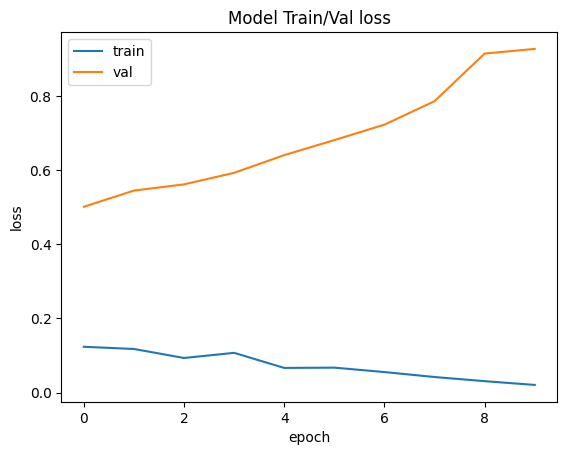

In [309]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train/Val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 25ms/step


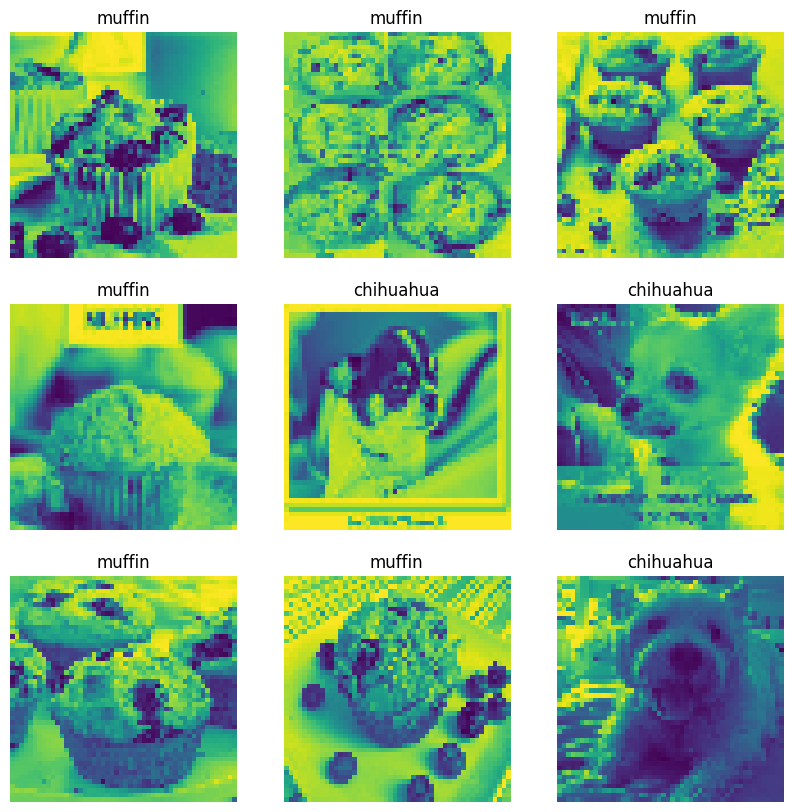

In [310]:
plt.figure(figsize=(10, 10))
for images, labels in ds_val.take(1): #loads batch of 9 images from ds_val
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

    img = images[i].numpy().astype('uint8')
    img_array = keras.preprocessing.image.img_to_array(img) #convert image to numpy
    img_array = tf.expand_dims(img_array, 0)  #turning single image into array because the model expects an array of images
    predictions = model.predict(img_array) #pushing image into model
    score = predictions[0]
    if score > 0.5:
      plt.title('muffin')
    else:
      plt.title('chihuahua')
    plt.axis("off")